# 2.4 MLLib

`MLLib` is Spark's main machine learning library.  It focuses on algorithms that work well at large scales.

Like `Spark SQL`, `MLLib` has advanced a lot since Spark 1.2, in particular with respect to setting up machine learning pipelines.  Here, we'll stick to what's available in your production cluster.  Do keep an eye out for what becomes possible when your Big Data teams upgrades Spark.

One quick note: if you want to train lots of models over small data, rather than one gigantic model, it's best to use `scikit-learn`.  You can use `scikit-learn` within Spark, say by dividing your data into independent datasets and `map`-ping a `scikit-learn` algorithm on each such dataset. 

To get started, here's a complete (albeit simple) spam classification example drawn from [Learning Spark](http://shop.oreilly.com/product/0636920028512.do):

In [1]:
# First, prepare the data files
spamFile = open('spam.txt', 'w')
spamFile.write(
"""Dear sir, I am a Prince in a far kingdom you have not heard of.  I want to send you money via wire transfer so please ...
Get Viagra real cheap!  Send money right away to ...
Oh my gosh you can be really strong too with these drugs found in the rainforest. Get them cheap right now ...
YOUR COMPUTER HAS BEEN INFECTED!  YOU MUST RESET YOUR PASSWORD.  Reply to this email with your password and SSN ...
THIS IS NOT A SCAM!  Send money and get access to awesome stuff really cheap and never have to ...""")
spamFile.close()

normalFile = open('normal.txt', 'w')
normalFile.write(
"""Patrick, How are you?  Love, Dad
Dear all, attached are the IPython notebooks for today's session.
Paul, this is Joris from the Big Data team.  We've finally updated Spark in our cluster to 1.5.  Enjoy!
Dear Patrick, Your books from Amazon have now shipped!""")
normalFile.close()

In [2]:
# Record current working directory for future use
import os
cwd = os.getcwd()
cwd

'/Users/pat/Work/2015/PythonTraining/4DayTrainingOpenSource'

In [3]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.feature import HashingTF
from pyspark.mllib.classification import LogisticRegressionWithSGD

spam = sc.textFile("file://" + cwd + "/spam.txt")
normal = sc.textFile("file://" + cwd + "/normal.txt")

# First step, turn raw data into feature vectors =
# (using feature hashing here; TF stands for "term frequency")
tf = HashingTF(numFeatures = 1000)
# Each email is split into words, and each word is mapped to one feature
spamFeatures = (spam
                .map(lambda email: tf.transform(email.split(" "))))
normalFeatures = (normal
                  .map(lambda email: tf.transform(email.split(" "))))

# Now each feature vectored is labeled with a class, using
# MLLib's LabeledPoint type
positives =   spamFeatures.map(lambda features: LabeledPoint(1, features))
negatives = normalFeatures.map(lambda features: LabeledPoint(0, features))
trainingData = positives.union(negatives)
trainingData.cache()  # Cache since Logistic Regression is an iterative algorithm

# Run Logistic Regression using the SGD algorithm
model = LogisticRegressionWithSGD.train(trainingData)

# Test on a positive example (spam) and a negative one (normal).
# We first apply the same HashingTF feature transformation to get
# vectors, then apply the model.
posTest = tf.transform("O M G GET cheap stuff by sending money to ..."
                       .split(" "))
negTest = tf.transform("Dear Dad, Spark is great!  Love, Pat"
                       .split(" "))
print("Prediction for posTest: {0}".format(model.predict(posTest)))
print("Prediction for negTest: {0}".format(model.predict(negTest)))

Prediction for posTest: 1
Prediction for negTest: 0


Not so hard, is it?  A very simplified and general structure of any machine learning algorithm, captured in the above example, is shown below:

<img src="images/MLOverview.png">  
Image Source: [Learning Spark](http://shop.oreilly.com/product/0636920028512.do)

Now let's look at the building blocks available in MLLib to put such a pipeline together.

The first building block is the `Vector` type for storing **feature vectors**.  These are just arrays of numbers, or **weights**.  `MLLib` provides special support for the common case of sparse feature vectors, where most weights are 0.

In [4]:
from pyspark.mllib.linalg import Vectors

In [5]:
# A dense feature vector
dfv = Vectors.dense([1.0, 0.0, -5.0, 6.5])
dfv

DenseVector([1.0, 0.0, -5.0, 6.5])

A `DenseVector` is a thin wrapper over a `NumPy` array, and you can get the array back out:

In [6]:
dfv.toArray()

array([ 1. ,  0. , -5. ,  6.5])

In [7]:
type(dfv.toArray())

numpy.ndarray

To create a sparse vectors, tell `MLLib` which elements are nonzero and what their values are:

In [8]:
# A sparse feature vector with 100 elements
# Only elements 21 and 67 are non-zero
sfv = Vectors.sparse(100, {21: 4.5, 67: -3.2})
sfv

SparseVector(100, {21: 4.5, 67: -3.2})

You *can* convert a Sparse Vector to a dense NumPy array, but you typically just want to know about the non-zero elements:

In [9]:
# Return a dense NumPy Array
sfv.toArray()

array([ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  4.5,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. , -3.2,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ])

In [10]:
# But usually, work with nonzero values directly
print("Indices: {0}".format(sfv.indices))
print("Values: {0}".format(sfv.values))

Indices: [21 67]
Values: [ 4.5 -3.2]


Then there are labeled feature vectors, represented by the type **`LabeledPoint`**:

In [11]:
from pyspark.mllib.regression import LabeledPoint
lp1 = LabeledPoint(0, dfv)
lp2 = LabeledPoint(1, sfv)
lp3 = LabeledPoint(2, Vectors.dense([4.5, 1.0]))
print(lp1)
print(lp2)
print(lp3)

(0.0,[1.0,0.0,-5.0,6.5])
(1.0,(100,[21,67],[4.5,-3.2]))
(2.0,[4.5,1.0])


You can extract the label and feature vector from a `LabeledPoint`:

In [12]:
print(lp1.label)
print(lp1.features)

0.0
[1.0,0.0,-5.0,6.5]


In [13]:
lp1.features.toArray()

array([ 1. ,  0. , -5. ,  6.5])

**Note:** `MLLib` also implements recommendation algorithms where the basic data type is called `Rating`.  We won't talk about these algorithms here.

`MLLib` then provides various `Model` classes to implement regression and classification of labeled points, as well as clustering and dimensionality reduction on unlabeled feature vectors.

To illustrate `MLLib` models, let's redo the examples from the `scikit-learn` section using `MLLib`, just with more points:

In [14]:
# MatplotLib and NumPy are still useful when working with MLLib
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

# Optional: importing this package makes the default plot settings nicer
import seaborn as sns; sns.set()

## Linear regression

To explore linear regression, let's generate some noisy data that tracks a line:

In [15]:
def linear_data_sample(N=4000, rseed=0, m=3, b=-2):
    """Sample N points on the line y = m*x + b + err, where err is normally distributed"""
    rng = np.random.RandomState(rseed)

    x = 10 * rng.rand(N)
    y = m * x + b + 1.5*rng.randn(N)

    return sc.parallelize([LabeledPoint(yy, [xx]) for xx, yy in zip(x,y)])

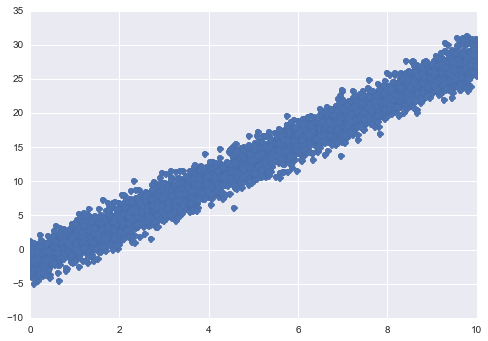

In [16]:
pointsRDD = linear_data_sample()
plt.plot(pointsRDD.map(lambda pt: pt.features[0]).collect(),
         pointsRDD.map(lambda pt: pt.label).collect(),
         'o');

`MLLib`, like `scikit-learn`, has a built-in linear regression code:

In [17]:
from pyspark.mllib.regression import LinearRegressionWithSGD
model = LinearRegressionWithSGD.train(
    pointsRDD, iterations=300, intercept=True, step=0.1
)
model

(weights=[2.91546762871], intercept=-1.4125729076660045)

**WARNING:** `SGD` above means Stochastic Gradient Descent, which doesn't converge as reliably and quickly as the normal Steepest Descent algorithm (but does parallelize much better).  I had to set `step=0.1` instead of the default `step=1.0`, as well as do lots of iterations, for the above to converge.

**WARNING 2:** Unless `iterations` is set to an extremely large number, the results will depend on the cluster on which you run.  The above works on my 4-core laptop, but I have seen instances of this regression failing to converge on different laptops or on a cluster.  In general, linear regression with SGD is [very](http://stackoverflow.com/questions/28232132/linear-regression-in-apache-spark-giving-wrong-intercept-and-weights) [fragile](http://apache-spark-user-list.1001560.n3.nabble.com/Inaccurate-Estimates-from-LinearRegressionWithSGD-td942.html) in MLLib.

Most `MLLib` algorithms follow the naming convention:
```
<ML task>With<Numerical algorithm>
```

As in `scikit-learn`, we can ask a model for predictions:

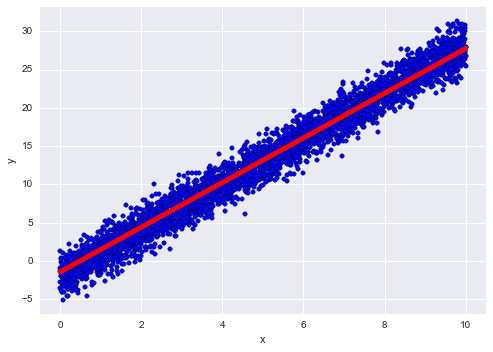

In [18]:
# predict y from the data
x_new = np.linspace(0, 10, 100)
y_new = np.array([model.predict([x]) for x in x_new])

# plot the results
ax = plt.axes()
ax.scatter(pointsRDD.map(lambda pt: pt.features[0]).collect(),
           pointsRDD.map(lambda pt: pt.label).collect())
ax.plot(x_new, y_new, 'r-', lw=5)

ax.set_xlabel('x')
ax.set_ylabel('y')

ax.axis('tight');

Notice that the fit can still be improved with more iterations...

**Ex 2.4.1: What's the equation of the line of best fit?**

**Ex 2.4.2: What's the predicted value of `y` for `x = 2.5`?**

**Ex 2.4.3  What are the weights of the linear regression if you use 500 iterations?**

**Ex 2.4.4 How would you add regularisation?  Refit the model with an L2 regularization parameter of 0.01.  Is the model at 300 iterations closer to the ground truth?**

**Ex 2.4.5 One objective way of saying whether a model is "better" or "worse" than another is to score the model against some test data.**
1. **Build a function to calculate the average squared distance between model and reality against an RDD of LabeledPoints**
2. **Split the data into 80% training and 20% test data (_Hint_: every RDD in Spark can be split randomly).  Now evaluate the improvement in the unregularized model between 100, 200 and 300 iterations**

In case you're wondering, `MLLib` does include built-in scoring functions for its models, but only in later versions of Spark, not in Spark 1.2 ...

## Classification

We used SVM's for `scikit-learn`.  Let's repeat the same calculation with `MLLib`, but with more data points.  We'll still use `scikit-learn` to make the simulated data because of its convenience.

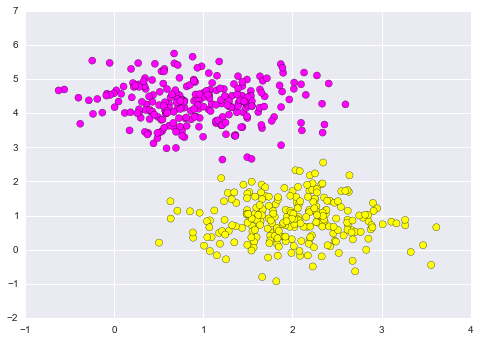

In [19]:
# SVMs
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=500, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring');

But we have to convert the data now to `LabeledPoint`s:

In [20]:
pointsRDD = sc.parallelize([
        LabeledPoint(yy, [XX0, XX1])
        for XX0, XX1, yy in zip(X[:, 0], X[:, 1], y)
    ])
pointsRDD.take(5)

[LabeledPoint(0.0, [0.618481655476,4.27224694969]),
 LabeledPoint(1.0, [2.16562281804,0.666369803713]),
 LabeledPoint(0.0, [0.736600660989,4.52582086016]),
 LabeledPoint(0.0, [2.0159027907,4.71448799156]),
 LabeledPoint(1.0, [2.63168356051,1.69510136786])]

In [21]:
from pyspark.mllib.classification import SVMWithSGD

In [22]:
model = SVMWithSGD.train(pointsRDD, iterations=100, intercept=True)
model

(weights=[1.04479094815,-1.12344788634], intercept=1.2838868513242965)

Let's compare the predictions to the real values for the first few points:

In [23]:
pointsRDD.map(lambda pt: (model.predict(pt.features), pt.label)).take(10)

[(0, 0.0),
 (1, 1.0),
 (0, 0.0),
 (0, 0.0),
 (1, 1.0),
 (0, 0.0),
 (0, 0.0),
 (0, 0.0),
 (1, 1.0),
 (0, 0.0)]

Let's visualize the decision boundary.  The decision function here is
$$
f(x,y) = w_0 x + w_1 y + c.
$$

Setting that to 0 gives us an equation for $y$ against $x$:
$$
y = -\frac{w_0 x + c}{w_1}.
$$

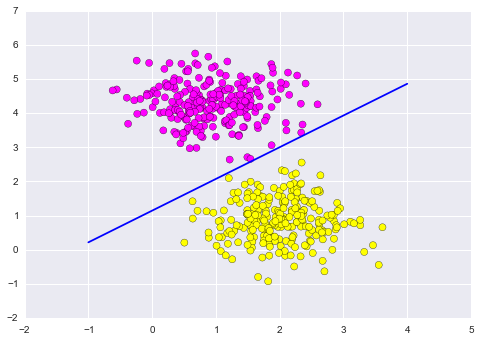

In [24]:
xlinspace = np.linspace(-1.0, 4.0, 50)
ydecision = -(model.weights[0] * xlinspace + model.intercept) / model.weights[1]

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring');
plt.plot(xlinspace, ydecision, 'b-')

**Ex 2.4.6  As in the `scikit-learn` example, we've cheated a bit by using all our data for the model, so that the SVM classifier looks perfect.  Let's do this better:**
1. **Split the original data into 60% training and 40% test**
2. **Fit the SVM model to the training data and calculate the model accuracy on the test data.**

**Ex 2.4.7 Repeat the exercise, but with clusters that are more spread out (`cluster_std = 1.5` instead of `cluster_std = 0.6`)**

## Dimensionality Reduction (PCA)

**OOPS!**  `MLLib`'s PCA code is only exposed in `Scala` and `Java`, not `Python` ...

## K-means

As before, we use `scikit-learn` to generate simulated data, just lots more of it:

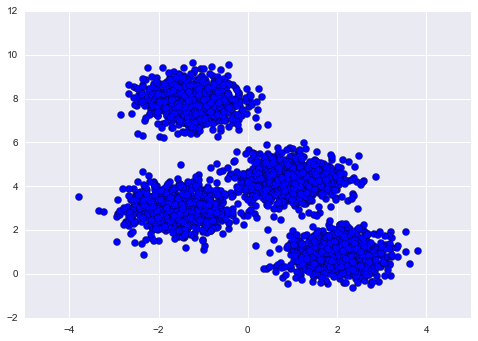

In [25]:
# Make fake clustered data
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=3000, centers=4,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], s=50);

In [26]:
# Turn the data into an RDD of DenseVectors
pointsRDD = sc.parallelize([
        Vectors.dense([x1, x2]) for x1, x2 in zip(X[:, 0], X[:, 1])
    ])
pointsRDD.take(5)

[DenseVector([-1.5124, 7.8685]),
 DenseVector([2.3001, -0.0803]),
 DenseVector([-1.0559, 3.0541]),
 DenseVector([2.1193, 1.8091]),
 DenseVector([0.8311, 5.2147])]

In [27]:
# Cluster into 4 clusters using K-means
from pyspark.mllib.clustering import KMeans

clusters = KMeans.train(pointsRDD, 4, maxIterations=10,
        runs=10, initializationMode="random")
print(clusters.centers)

[array([ 2.01461578,  0.89698901]), array([ 0.96531474,  4.28859914]), array([-1.24993275,  7.84646637]), array([-1.55247435,  2.91913877])]


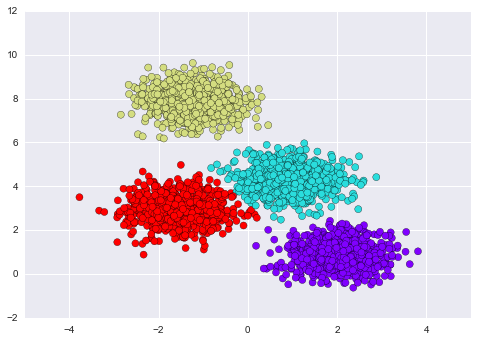

In [28]:
y_kmeans = pointsRDD.map(lambda v: clusters.predict(v)).collect()
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='rainbow');

---

As always, we've only scratched the surface.  The [MLLib documentation](http://spark.apache.org/docs/1.2.0/mllib-guide.html) is particularly complete and user-friendly, and I encourage you to look through it to see if you find anything useful for you.